**SSA Forecasting - Bao Ngoc Nguyen - UMass Amherst - Start: 3/20/2024 - End: undefined**

**Part 1: SSA Algorithm construction**

Importing dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Plotting stuff

In [2]:
def plot_2d(matrix, title):
    if len(matrix.shape) == 1:  # Check if matrix is 1D
        matrix = matrix.reshape(-1, 1)  # Reshape to a 2D matrix
    height, width = matrix.shape
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [3]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

Loading dataset

In [4]:
with open("dataset.txt", "r") as file_solieu:
    data = np.loadtxt(file_solieu, dtype={'names': ('col1', 'col2'), 'formats': ('int', 'float')}, unpack=True)

**Step 1: Decomposition**

Separate values of column 2

In [5]:
Fi = data[1][1:]

Defining variables

In [6]:
N = 100 # Number of signals to analyse
L = 50 # 2 < L < N - 1
K = N - L + 1
X = np.zeros((L, K)) # init X = (L, K)

In [7]:
for i in range(L): # Rows
    for j in range(K): # Columns
        X[i, j] = Fi[i + j]

Visualization of lagged vectors

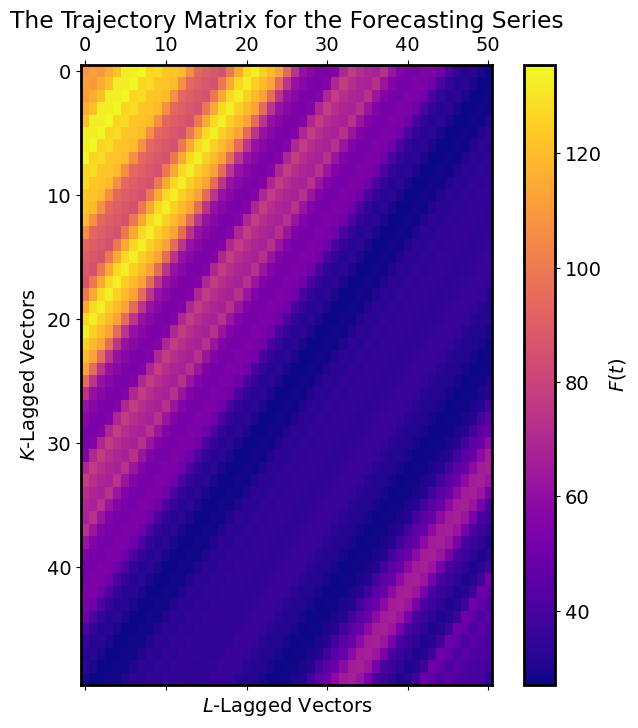

In [8]:
ax = plt.matshow(X, aspect='auto') # Plotting the X matrix
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.3)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Forecasting Series")
plt.show()

**Step 2: Singular Value Decomposition**

Calculate the SVD in which U = eigenvectors, V = processed vectors, Sigma = eigenvalues

In [9]:
U, Sigma, V = np.linalg.svd(X) # U = eigenvectors, V = processed vectors, Sigma = eigenvalues
V = V.T

Calculate the rank

In [10]:
d = 0
for i in range(L):
    if Sigma[i] > 0:
        d = i + 1

Visualization of the elementary matrices

In [11]:
Xsum = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

Show it!

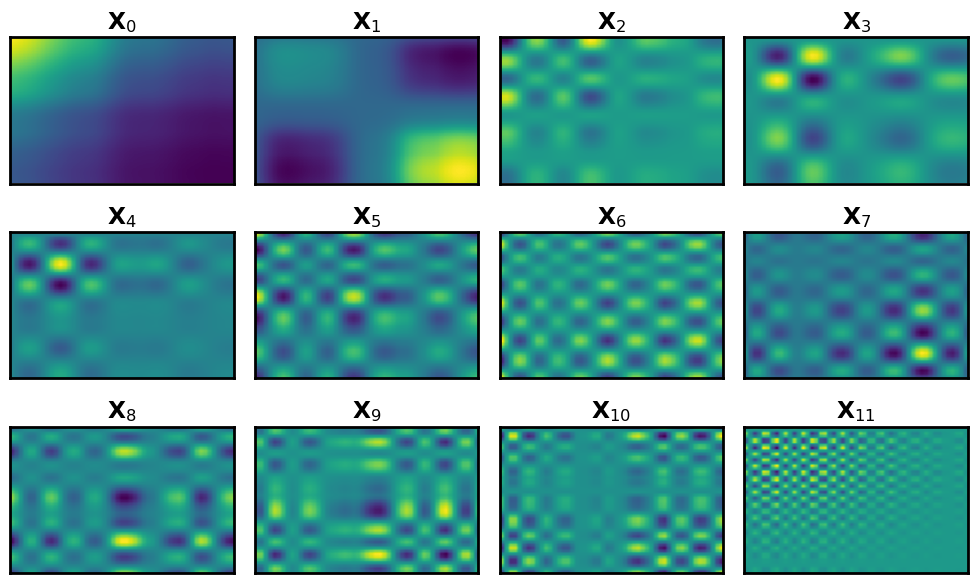

In [12]:
n = min(12, d)
for i in range(n):
    plt.subplot(4, 4, i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(Xsum[i], title)
plt.tight_layout()

**Step 3: Diagonal averaging**

Hankel function with input matrix X

In [13]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

Visualization of Henkel function matrices

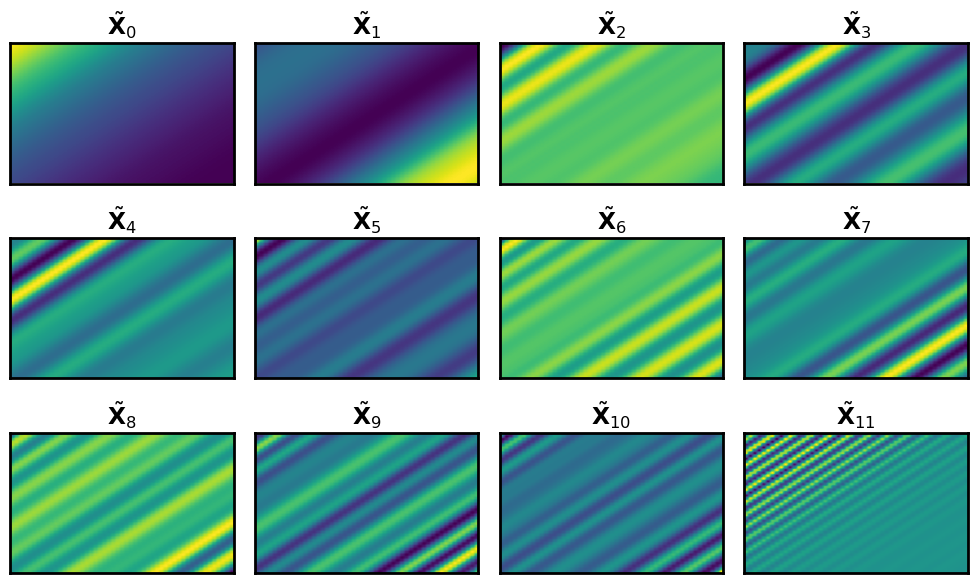

In [14]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(Xsum[j]), title)
plt.tight_layout()

Calculating the matrix stuff

In [15]:
Pi = U
PiT = np.transpose(Pi)

In [16]:
r = 3 # r is the linear space dimension, r < d
Xmusum = np.zeros((L, K)) # Init Xmusum = sum of Xmu(i)
for i in range(r):
    Xmusum += np.dot(np.outer(Pi[:, i], PiT[i, :]), X)

In [17]:
Y = Xmusum # Substitute of matrix Xmusum = Y
Lsao = min(L, K) # Init Lsao
Ksao = max(L, K) # Init Ksao
Ysao = np.zeros((L, K)) # Init Ysao
if L < K: # When L < K then Ysao(i,j) = Y(i,j)
    Ysao = Y
else: # When L >= K then Ysao(i,j) = Y(j,i)
    for i in range(Lsao):
        for j in range(K):
            Ysao[i, j] = Y[j, i]

Calculate g(1) to g(N)

In [18]:
g = np.zeros(N) # Init array g with length N
# Case 0 <= k < Lsao - 1 <=> 0 < h < Lsao
for h in range(0, Lsao - 1):
    s = 0
    for m in range(0, h + 1): # Calculate sum Ysao
        s += Ysao[m, h - m]
    g[h] = (s / (h + 1))
# Case Lsao - 1 <= k < Ksao <=> Lsao - 1 < h < Ksao + 1
for h in range(Lsao - 1, Ksao): # sub h = k + 1
    s = 0
    for m in range(0, Lsao): # Calculate sum Ysao
        s += Ysao[m, h - m]
    g[h] = (s / (Lsao))
# Case Ksao <= k < N => Ksao < h < N + 1
for h in range(Ksao, N): # sub h = k + 1
    s = 0
    for m in range(h - Ksao + 1, N - K + 1): # Calculate sum Ysao
        s += Ysao[m, h - m]
    g[h] = (s / (N - h))

**Part 2: SSA Forecasting**

Boring formulas

In [19]:
nuy2 = 0 # Init nuy2
for i in range(r):
    nuy2 += Pi[L - 1, i] ** 2 # Calculate nuy2 = π1^2 + . . . + πr^2

# Calculate R using formula 2.1
tempR = np.zeros(L - 1) # Init tempR
for i in range(r): # Calculate sum Pi(L,i) * Pi(1:L-1,i)
    tempR += Pi[L - 1, i] * Pi[0:L - 1, i]

R = 1 / (1 - nuy2) * tempR # Calculate R
a = np.flipud(R) # Calculate a = matrix fliper of R

Calculate g(N + 1) -> g(N + M) using formula in article

In [20]:
M = 30 # Init extra steps we want to forecast
gpredict = np.zeros(N + M) # Calculate g(i) with i=N+1:N+M
for i in range(100):
    gpredict[i] = g[i]

for i in range(N, N + M):
    gpredict[i] = 0
    for j in range(0, L - 1):
        gpredict[i] += (a[j] * gpredict[i - j - 1])

**Part 3: Graphing**

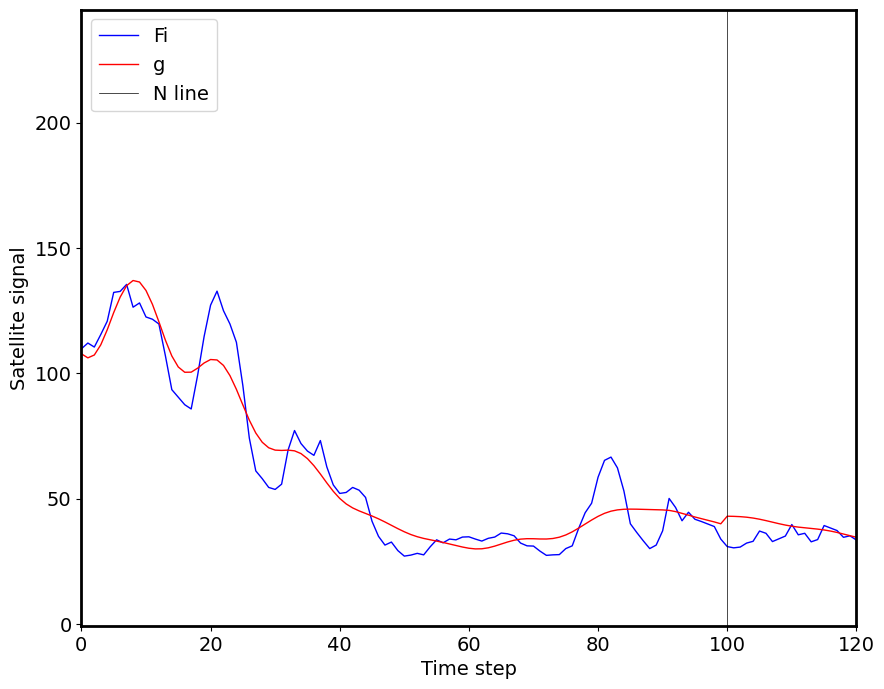

In [21]:
# g is now replaced by gpredict
# Draw the comparison graphs
plt.figure()
plt.plot(Fi, linewidth=1, linestyle='-', color='b', label='Fi') # Draw Fi
plt.plot(gpredict, linewidth=1, linestyle='-', color='r', label='g') # Draw forecasting line g
plt.axvline(x=N, linewidth=0.5, linestyle='-', color='k', label='N line') #  y = N

plt.xlabel('Time step') #  Time step
plt.ylabel('Satellite signal') # Satellite signal
plt.legend() # Output legend
plt.xlim([0, N]) # Limit x
plt.xticks(range(0, N + M, 20)) # Limit y
plt.show() # Show it!